In [1]:
!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
import csv

# Download stopwords
nltk.download('stopwords')

2025-05-05 20:21:59.628992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746494519.647539     863 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746494519.653129     863 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 20:21:59.673091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

True

In [3]:
# Load and combine multiple datasets
files = ["test.csv", "test1.csv", "test2.csv"]
dfs = [pd.read_csv(file, sep='	') for file in files]
df = pd.concat(dfs, ignore_index=True)  # Replace with your actual file path


In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prompt           600 non-null    object 
 1   human            600 non-null    object 
 2   ai               600 non-null    object 
 3   sentiment label  200 non-null    float64
dtypes: float64(1), object(3)
memory usage: 18.9+ KB


In [5]:
# Extract sentiment label if available and convert to numeric
if 'sentiment label' in df.columns:
    df['sentiment_label_clean'] = df['sentiment label'].astype(str).str.extract(r'(Positive|Negative|Neutral)', expand=False)
    df['sentiment_score_label'] = df['sentiment_label_clean'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}).fillna(0)
else:
    df['sentiment_score_label'] = 0


In [6]:
# Combine prompt with responses
df['human_text'] = df['prompt'] + " " + df['human']
df['ai_text'] = df['prompt'] + " " + df['ai']

In [7]:

# Create unified training DataFrame
human_df = pd.DataFrame({'text': df['human_text'], 'generated': 0, 'sentiment_score_label': df['sentiment_score_label']})
ai_df = pd.DataFrame({'text': df['ai_text'], 'generated': 1, 'sentiment_score_label': df['sentiment_score_label']})
train_essays = pd.concat([human_df, ai_df], ignore_index=True)


In [8]:
train_essays.head(1500)

,text,generated,sentiment_score_label
0,The code itself was patterned so that most con...,0,0.0
1,San Diego and its backcountry are subject to p...,0,0.0
2,I Love New York (stylized I ❤ NY) is both a lo...,0,0.0
3,Amensalism is an interaction where an organism...,0,0.0
4,"By the census of 1971, the population of Lanca...",0,0.0
...,...,...,...
1195,Object: Fremont's response to a negative revie...,1,0.0
1196,"Object: restaurant\n\nKey words: lunch, sushi,...",1,0.0
1197,"Object: Lotus Cafe\n\nKey words: ordered, food...",1,0.0
1198,Object: Boulders on Broadway bar\nKey words: n...,1,0.0


In [9]:
# Explore the training data
train_essays.info()
train_essays.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   text                   1200 non-null   object 
 1   generated              1200 non-null   int64  
 2   sentiment_score_label  1200 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.3+ KB


,text,generated,sentiment_score_label
0,The code itself was patterned so that most con...,0,0.0
1,San Diego and its backcountry are subject to p...,0,0.0
2,I Love New York (stylized I ❤ NY) is both a lo...,0,0.0
3,Amensalism is an interaction where an organism...,0,0.0
4,"By the census of 1971, the population of Lanca...",0,0.0


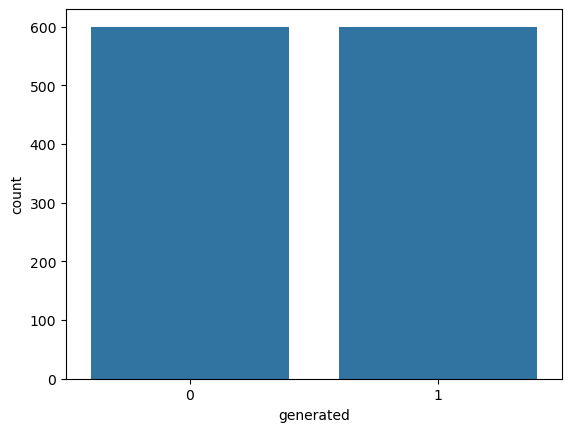

In [10]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


In [11]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', str(text))
    words = text.split()
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)


In [12]:
# Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

train_essays['vader_score'] = train_essays['clean_text'].apply(get_sentiment_score)

# Combine VADER and sentiment label as input features
vader_tensor = torch.tensor(train_essays['vader_score'].values, dtype=torch.float32).unsqueeze(1)
label_tensor = torch.tensor(train_essays['sentiment_score_label'].values, dtype=torch.float32).unsqueeze(1)
combined_sentiment_tensor = torch.cat([vader_tensor, label_tensor], dim=1)


In [13]:

# Split dataset with stratification
X_train_text, X_val_text, y_train, y_val, X_train_sent, X_val_sent = train_test_split(
    train_essays['clean_text'], train_essays['generated'], combined_sentiment_tensor, 
    test_size=0.15, random_state=42, stratify=train_essays['generated'])


In [14]:
# Tokenize using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_encodings = tokenizer(X_train_text.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(X_val_text.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)


In [15]:
# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor = torch.tensor(y_val.values)


In [16]:
# Create datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], X_train_sent, y_train_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], X_val_sent, y_val_tensor)


In [17]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [18]:
# BERT model with sentiment inputs
class BertWithCombinedSentiment(torch.nn.Module):
    def __init__(self):
        super(BertWithCombinedSentiment, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        self.sentiment_fc = torch.nn.Linear(2, 2)

    def forward(self, input_ids, attention_mask, sentiment_tensor):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sentiment_out = self.sentiment_fc(sentiment_tensor)
        return outputs.logits + sentiment_out

model = BertWithCombinedSentiment()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, sent_tensor, labels in train_loader:
        input_ids, attention_mask, sent_tensor, labels = input_ids.to(device), attention_mask.to(device), sent_tensor.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, sent_tensor)
        loss = torch.nn.functional.cross_entropy(logits, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0174
Epoch 2, Loss: 0.0001
Epoch 3, Loss: 0.0001
Epoch 4, Loss: 0.0117
Epoch 5, Loss: 0.0268
Epoch 6, Loss: 0.0001
Epoch 7, Loss: 0.0001
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0302
Epoch 10, Loss: 0.0172


In [25]:
# Evaluation
model.eval()
val_preds, val_labels_all = [], []
with torch.no_grad():
    for input_ids, attention_mask, sent_tensor, labels in val_loader:
        input_ids, attention_mask, sent_tensor = input_ids.to(device), attention_mask.to(device), sent_tensor.to(device)
        logits = model(input_ids, attention_mask, sent_tensor)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels_all.extend(labels.numpy())


In [26]:
# Metrics
acc = accuracy_score(val_labels_all, val_preds)
f1 = f1_score(val_labels_all, val_preds)
print(f"\nValidation Accuracy (BERT + VADER + Labeled Sentiment): {acc:.2f}")
print(f"F1 Score (BERT + VADER + Labeled Sentiment): {f1:.2f}")
print("Classification Report:")
print(classification_report(val_labels_all, val_preds, target_names=['Human', 'AI']))



Validation Accuracy (BERT + VADER + Labeled Sentiment): 0.94
F1 Score (BERT + VADER + Labeled Sentiment): 0.94
Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.90      0.94        90
          AI       0.91      0.98      0.94        90

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



In [27]:
# Metrics
acc = accuracy_score(val_labels_all, val_preds)
f1 = f1_score(val_labels_all, val_preds)
print(f"\nValidation Accuracy (BERT + VADER): {acc:.2f}")
print(f"F1 Score (BERT + VADER): {f1:.2f}")
print("Classification Report (BERT + VADER):")
print(classification_report(val_labels_all, val_preds, target_names=['Human', 'AI']))

# Generate prediction probabilities on full dataset
train_essays['id'] = range(len(train_essays))
test_inputs = tokenizer(train_essays['clean_text'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

with torch.no_grad():
    sentiment_tensor = torch.cat([vader_tensor, label_tensor], dim=1).to(device)
    outputs = model(test_inputs['input_ids'], test_inputs['attention_mask'], sentiment_tensor)

    logits = outputs
    predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

submission = pd.DataFrame({
    'id': train_essays['id'],
    'text': train_essays['text'],
    'predicted_probability_AI': predictions
})

submission.to_csv('submission_bert_+_vader.csv', index=False)



Validation Accuracy (BERT + VADER): 0.94
F1 Score (BERT + VADER): 0.94
Classification Report (BERT + VADER):
              precision    recall  f1-score   support

       Human       0.98      0.90      0.94        90
          AI       0.91      0.98      0.94        90

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



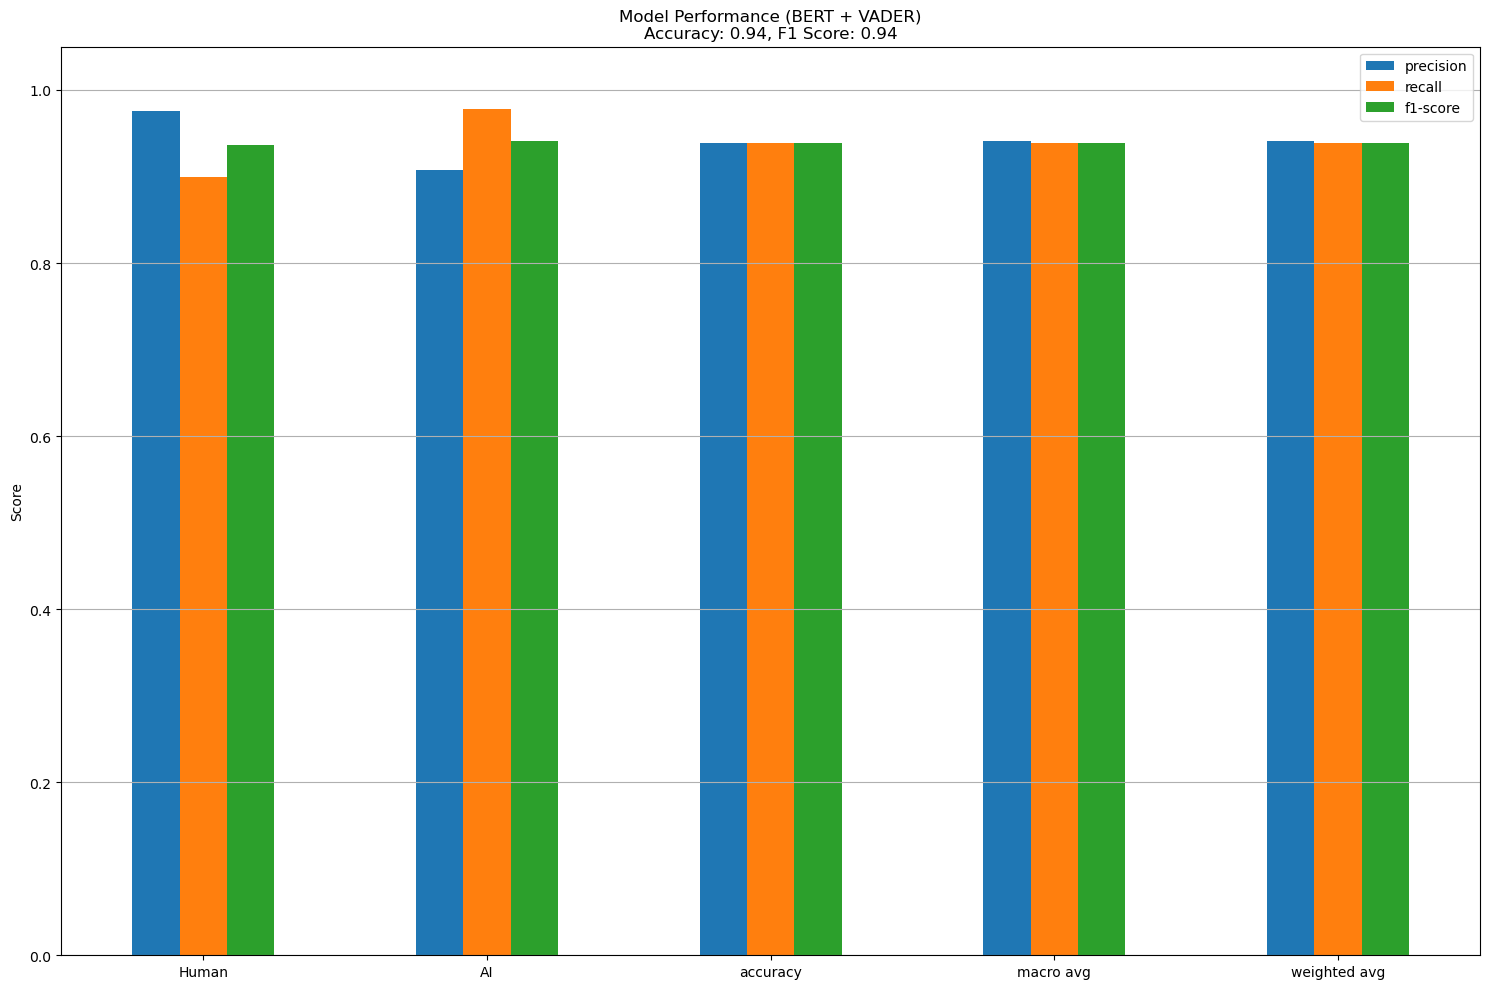

In [28]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Use the actual predictions and true labels from your model
y_true = val_labels_all  # or your actual ground truth labels
y_pred = val_preds       # or your predicted labels

# Generate the classification report dynamically
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Rename numeric class labels to 'Human' and 'AI' for better visuals
label_map = {'0': 'Human', '1': 'AI'}
df_report.rename(index=label_map, inplace=True)

# Extract overall accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Plot the full report
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 10))
plt.title(f"Model Performance (BERT + VADER)\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
